# Evaluate LLM results

Install Dependencies

In [1]:
# %%capture
# !pip install datasets==2.20.0
# !pip install -U langsmith==0.1.99
# !pip install langchain_openai==0.1.22
# !pip install langchain==0.2.13
# !pip install langchain_community==0.2.12                          
# !pip install transformers==4.44.0
# !pip install termcolor==2.4.0
# !pip install accelerate==0.33.0
# !pip install pandas==2.2.2
# !pip install openpyxl==3.1.5
# !pip install python-dotenv==1.0.1
# !pip install einops==0.8.0
# !pip install wheel==0.44.0
# !pip install sentencepiece==0.2.0
# !pip install protobuf==5.27.3 #Mistral models needs this
# !pip install groq==0.10.0 #Groq models needs this
# !pip install matplotlib==3.9.2
# !pip install seaborn==0.13.2

# !pip install flash-attn==2.6.3 #Install it at the end after wheel has been installed
# !pip install anthropic==0.34.1 #Anthropic models needs this

# #Only if CPU is used
# !pip install torch==2.0.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

RunPod specific parameters

In [2]:
#For RunPod change to persistent storage directory
import os
os.chdir('/workspace')

Specify Path and Load API Keys

In [3]:
file_path ='/workspace/Example_QA_data_raw.xlsx' #Dataset generated with the help of GPT-4o - Has to be an excel file with 'input' and 'output' columns
#'/Users/nikolaossourlo/Desktop/Example_QA_data_raw.xlsx' #For MacOS
#'C:/Users/soyrl/Desktop/Example_QA_data_raw.xlsx' #For Windows
# '/content/drive/My Drive/Example_QA_data_raw.xlsx' #For Google Colab
#'/home/nikolaossourlo/Example_QA_data_raw.xlsx' #For Delft Blue
# '/workspace/Example_QA_data_raw.xlsx' #For RunPod

custom_cache_dir="/workspace/cache/huggingface" #Save models here so that we don't have to download them again
#"/scratch/nikolaossourlo/cache" in Delft Blue

# Check if custom_cache_dir is defined, otherwise use default behavior
try:
    cache_dir=custom_cache_dir
except:
    cache_dir=None

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv(dotenv_path=os.getcwd()+"/env")

# Get the OpenAI API key
openai_api_key = os.getenv('OPENAI_API_KEY_DRACO')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')

#Login to Hugging Face
from huggingface_hub import login
# Log in with your Hugging Face token
login(token=os.getenv('HF_TOKEN'))

# print(openai_api_key)
# print(langsmith_api_key)

/workspace/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Select model and name for the experiment

In [4]:
#Model to generate responses to questions
models=[ 
    "meta-llama/Meta-Llama-3.1-8B-Instruct", #Takes 2.5-3mins in A4500 (20GB VRAM) and in Delft Blue (35min for 44Q&A pairs in V100 32GB)
    "microsoft/Phi-3.5-mini-instruct", #Took 5mins in A40 with 48GB VRAM, 2mins in A4500 with 20GB VRAM, 3mins in Delft Blue (50min for 44Q&A pairs in V100 32GB)
    "mistralai/Mistral-7B-Instruct-v0.3", #4mins in A40 with 48GB VRAM, 2.5mins in A4500 with 20GB VRAM and in Delft Blue
    "Qwen/Qwen2-7B-Instruct", #4mins in A40 with 48GB VRAM, 2 mins in A4500 with 20GB VRAM, 2.5mins in Delft Blue
    'AI-MO/NuminaMath-7B-TIR', #2.5 in A4500 with 20GB VRAM and in Delft Blue - We can also try 01-ai/Yi-Coder-9B-Chat
    'microsoft/Phi-3-mini-4k-instruct', #6 mins in RTX3090
    "google/gemma-2-9b-it", #More than 20GB of GPU memory needed - Works with A40 with 48GB VRAM (8mins), and with V100 32GB (not with A4500, 20GB), 4.5mins in Delft Blue
    'mistralai/Mistral-Nemo-Instruct-2407', #12B parameters, 11mins in 2 RTX3090, 16mins in V100 with 32GB VRAM (48mins to run over all 44 Q&A pairs)
    'openai/gpt-4o-mini' #Costs very low ~0.01$ for 9 Q&A pairs.
    ] #All above models need ~130GB space, the last needs ~30GB . For 44 Q&A pairs it takes ~50min/model

# Groq models are defined as: groq_website/model_name e.g. 'groq_website/llama-3.1-70b-versatile'
# OpenAI models are defined as: 'openai/model_name', e.g. 'openai/gpt-4o-mini'
# Anthropic models are defined as 'anthropic/model_name', e.g. 'anthropic/claude-3-haiku-20240307' - Couldn't use due to billing issues

# I couldn't run 'nvidia/Mistral-NeMo-Minitron-8B-Base', "hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4" (Conflicting dependencies),
# 'google/recurrentgemma-9b-it' # RecurrentGemmaForCausalLM.forward() got an unexpected keyword argument 'position_ids'

#Define model to act as a judge
judge_model='openai/gpt-4o-mini' #If used with Llama, only 0.01$ for 9 Q&A pairs for gpt-4o-mini, and 0.22$ for gpt-4o

#Define maximum number of tokes in the judge LLM output
max_output_tokens=500

#Limit of tokens in the generated response from LLM
generate_max_tokens=1000

#Inference on whole dataset?
inference_on_whole_dataset=True

Define prompts for custom evaluation metrics

In [5]:
common_prompt="""
You are an autoregressive language model that acts as a judge in comparing a predicted vs an actual answer to a questions.
Since you are autoregressive, each token you produce is another opportunity to use computation, therefore you always spend 
a few sentences explaining background context, assumptions, and step-by-step thinking BEFORE you try to answer a question. 
Your users are experts in chemical engineering, so they already know you're a language model and your capabilities and limitations, so don't 
remind them of that. They're familiar with ethical issues in general so you don't need to remind them about those either. 
Don't be verbose in your answers, but do provide details and examples where it might help the explanation. 
""" #This is common for all prompts below

In [6]:
completeness_descr = """
Your task is to evaluate a given response with regards to completeness. The completeness metric evaluates the extent to which the question in the user's prompt is answered
in full. You can assign a score from 1 to 5, with the following interpretations:
1: There is no response.
2: No parts of a suitable answer are present.
3: Few elements of a complete answer are present.
4: Most elements of a complete answer are present.
5: The response covers all elements of a complete answer.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

relevance_descr = """
Your task is to evaluate a given response with regards to relevance. The relevance metric evaluates the amount of irrelevant information in the response considering 
the user's original question. You can assign a score from 1 to 5, with the following interpretations:
1: The response answers something else, not the user's question.
2: The response answers the user's question but the information provided is mostly irrelevant.
3: The response answers the user's question but contains more irrelevant information than relevant information.
4: The response answers the user's question, and shares a bit of irrelevant information.
5: The response answers the user's question and contains no irrelevant information.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

conciseness_descr = """
Your task is to evaluate a given response with regards to conciseness. The conciseness metric evaluates the amount of unexpected extra information in the response
considering the user's original question. You can assign a score from 1 to 5, with the following interpretations:
1: The response is too long and stops before completion or enters an infinite loop.
2: The response includes a lot of extra information and uses flowery language.
3: The response includes a lot of extra information or uses flowery language.
4: The response is short and includes a small amount of extra information.
4: The response is as short as possible while still answering the prompt.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

confidence_descr = """
Your task is to evaluate a given response with regards to confidence. The condifence metric evaluates the degree of assurance that is conveyed the response that 
the provided answer is correct. You can assign a score from 1 to 5, with the following interpretations:
1: Complete Rejection. The response makes it clear that the given answer is incorrect or that no correct answer can be provided.
2: Doubt and Disagreement. The response suggests that the answer is likely incorrect or raises significant concerns.
3: Uncertainty. The response indicates that the answer could be correct, but there is significant doubt or insufficient evidence.
4: Moderate Agreement. The response leans towards the answer being correct but acknowledges some uncertainty.
5: Full Endorsement. The reponse confidentely asserts that the given answer is correct.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

factuality_descr = """
Your task is to evaluate a given response with regards to factuality. The factuality metric evaluates the degree of hallucination contained in a response or, 
in other words, how accurate a given response is. You can assign a score from 1 to 5, with the following interpretations:
1: The response is a complete hallucination
2: The response is mostly a hallucination but does not change key information from the prompt (such as chemical identifiers).
3: The response contains large amounts of both hallucinations and factual information.
4: The response includes mostly factual information with slight hallucinations.
5: The response only includes factual information.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

judgement_descr = """
Your task is to evaluate a given response with regards to judgement. The judgment metric assesses how strongly the response implies its correctness, taking 
into account the actual accuracy of the answer. You can assign a score from 1 to 5, with the following interpretations:
1: The response confidently claims a hallucination as truth.
2: The response misinterprets information received in the prompt.
3: The response shows that the model is unsure about the answer or states that information is theoretical.
4: The response is wrong but it is made clear that the answer is wrong or that the model is unable to provide a correct answer.
5: The response is correct.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

In [7]:
#How the dataset will be named in Langsmith
def get_dataset_name(model_name, judge_model):
    try: #For Hugging Face models
        return "Chemical_Engineering_Evaluation_"+model_name.split('/')[1]+'_with_judge_'+judge_model
    except: #For OpenAI models
        return "Chemical_Engineering_Evaluation_"+model_name+'_with_judge_'+judge_model

Check if GPU is available

In [8]:
import torch
print(torch.version.cuda)

12.1


Google Drive mount (If run in Colab)

In [9]:
if 'content/drive/My Drive' in file_path:
    from google.colab import drive
    drive.mount('/content/drive')

Read Excel File

In [10]:
import pandas as pd
qa=pd.read_excel(file_path) #Read Excel

Create Dataset from df

In [11]:
from datasets import Dataset
loaded_dataset=Dataset.from_pandas(qa)

if inference_on_whole_dataset==False:
    loaded_dataset = loaded_dataset.train_test_split(test_size=0.2, seed=42) #Used if going to fine-tune in part of the dataset

In [12]:
if inference_on_whole_dataset==False:
    dataset_train=loaded_dataset['train']
    dataset_test=loaded_dataset['test']
else:
    dataset_test=loaded_dataset #When we use the whole dataset

Create Langsmith Test Dataset

In [13]:
#https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets

from langsmith import Client

example_inputs = [(x['input'],x['output']) for x in dataset_test]
print(example_inputs)

def create_langsmith_dataset(dataset_name, example_inputs, langsmith_api_key):

    client = Client(api_key=langsmith_api_key)

    try:
        #Load the dataset if already exists
        for existing_dataset in client.list_datasets():
            if existing_dataset.name==dataset_name:
                dataset_langsmith=existing_dataset
        for x in dataset_langsmith:
            print("Dataset Loaded")
            break

    except: #Otherwise create it
        print("Dataset not found. Creating new dataset")
        # Storing inputs in a dataset lets us run chains and LLMs over a shared set of examples.
        dataset_langsmith = client.create_dataset(dataset_name=dataset_name,
                                                description="Q&A chemical engineering.")

        for input_prompt, output_answer in example_inputs:
            client.create_example(
                inputs={"question": input_prompt},
                outputs={"answer": output_answer},
                # metadata={"source": "Wikipedia"},
                dataset_id=dataset_langsmith.id,
            )

    return dataset_langsmith

[('What was the first appearance of process intensification in chemical engineering?', 'The first appearance fo process intensification as we know it today was marked by the paper on application of centrifugal fields, or so called "HiGee". Here centrifugal fields in zero gravity are used to enhance transfer rates.'), ('Give some examples of technologies used in process intesification.', 'Examples of process intensifications would be: rotating equipment, heat exchanger reactors, intensive mixing devices or microchannel reactors.'), ('What is the difference between general process optimization and PI?', 'General process optimization focuses on improving overal process performance through incremental changes, while process intensification aims to achieve these improvements by fundamentally changing a process.'), ('Could you give a concrete example of the distinction of PSE and PI? ', 'The example for process systems engineering comes from the middle-ages, where cold was retrieved from gol

Custom Evaluation Metrics

In [14]:
# https://docs.smith.langchain.com/old/cookbook/introduction
# https://docs.smith.langchain.com/old/evaluation/faq/custom-evaluators
# https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#use-a-summary-evaluator

from langsmith.schemas import Run, Example
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from termcolor import colored

list_of_metrics=['completeness_descr','relevance_descr','conciseness_descr','confidence_descr','factuality_descr','judgement_descr']

#Function that compares the real answer with the predicted answer of an LLM and returns a score based on the evaluation
def factor_evaluator(run: Run, example: Example) -> dict: 
    # print("Run:",run)

    question=run.inputs.get("inputs")['question']
    # print("Question:",question)
    actual_answer = example.outputs.get("answer")
    # print("Real answer:",example.outputs.get("answer"))
    predicted_answer = run.outputs.get("output")
    # print("Predicted Answer:",answer)
    
    # Check if there is output from LLM
    if not predicted_answer:
        print("No output from LLM")
        return {"key": "custom_metric" , "score": 0} 
    
    else:
        scores={} #Store scores for each metric
        descriptions={} #Store descriptions for each metric
        
        for metric_name in list_of_metrics: #Iterate through all metrics
            print("Evaluating based on:",metric_name)
            metric_value=common_prompt+eval(metric_name) #Get the actual description of the metric

            # Define roles and placeholders
            chat_template = ChatPromptTemplate.from_messages(
            [("system", metric_value),
                ("user", "Question: {question}, Actual answer: {actual_answer}, Predicted answer: {predicted_answer}"),
                # ("ai", "It's sunny and warm outside."), #Use this if we want to use few shot prompts
            ]
            )

            messages = chat_template.format_messages(question=question, actual_answer=actual_answer, predicted_answer=predicted_answer)
            # print("Messages:",messages)

            formatted_messages = [(role, msg.content) for role, msg in zip(["system", "user"], messages)]
            # print("Formatted messages:",formatted_messages) #[('system', 'You are an autoregressive lan....', 'user':.....)]

            # Initialize the model and get response
            llm = ChatOpenAI(model_name=judge_model.split('/')[1], api_key=openai_api_key, temperature=0, max_tokens=max_output_tokens, seed=42)
            ai_response = llm.invoke(formatted_messages)

            # Output
            # print(colored("System message:"+ messages[0].content,'blue'))
            print(colored("User message:"+ messages[1].content, 'green'))
            print(colored("AI message:"+ ai_response.content,'red'))

            #Decide what the final score is based on output
            if "FINAL SCORE:" in ai_response.content: 
                score = int(ai_response.content.split("FINAL SCORE:")[1])
            else:
                print("Invalid response from LLM:", ai_response.content)
                score = 0

            scores[metric_name]=score
            descriptions[metric_name]=ai_response.content
            print("Scores:",scores)
            print("\n")

    return {
        "results":[ #We always need 'key', 'score' pairs
            {"key": "completeness" , "score": scores['completeness_descr'],"value":descriptions['completeness_descr']},
            {"key": "relevance" , "score": scores['relevance_descr'], "value":descriptions['relevance_descr']},
            {"key": "conciseness" , "score": scores['conciseness_descr'], "value":descriptions['conciseness_descr']},
            {"key": "confidence" , "score": scores['confidence_descr'], "value":descriptions['confidence_descr']},
            {"key": "factuality" , "score": scores['factuality_descr'], "value":descriptions['factuality_descr']},
            {"key": "judgement" , "score": scores['judgement_descr'], "value":descriptions['judgement_descr']}
        ]
    }

Define Models that Generate Responses

In [15]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.random.manual_seed(0) #Set for reproducibility

def initialize_model(model_id):
    # # Check if mps acceleration is available (For MacOS)
    # device = "mps" if torch.backends.mps.is_available() else "cpu"
    # print(f"Using device {device}")
    # model.to(device)

    # transformers.set_seed(42) #Tried for reproducibility but didn't work
    
    pipeline = transformers.pipeline( 
            "text-generation",
            model=model_id,
            model_kwargs={"torch_dtype": torch.bfloat16, "cache_dir":cache_dir},
            # trust_remote_code=True,
            device_map="auto" #Use 'cuda' if one GPU available (works in Delft Blue with 32GB VRAM) - 'auto' the alternative for distributed over all available GPUs
        )
    return pipeline

def get_model(model_id):
    """Given a model name, return the loaded model, tokenizer, and pipeline"""

    if 'openai' not in model_id and 'groq_website' not in model_id: #For Hugging Face models
        pipeline=initialize_model(model_id)

    #Returns below variables if defined, and returns None for any that are not.
    model = locals().get('model', None)
    tokenizer = locals().get('tokenizer', None)
    pipeline = locals().get('pipeline', None)

    return model, tokenizer, pipeline

Generate Responses

In [16]:
import time

def predict(inputs: dict) -> dict:
    """Given a question, return the answer from the model"""
    
    #Get these variables from the global scope
    global model_name
    
    messages = [ #Only use the questions to ask the model to generate the response
      {"role": "user", "content": inputs['question']},
    ]

    if 'gemma' not in model_name: #Gemma doesn't support system message
      messages.insert(0, {"role": "system", "content": "You are a language model specialized in chemical engineering. Answer the following question:"})
    else: #For gemma add system prompt in user message
      messages[0]['content']="You are a language model specialized in chemical engineering. Answer the following question: " + messages[0]['content']
    # print("Prompt:",messages)

    generation_args = { 
        "max_new_tokens": max_output_tokens, 
        "return_full_text": False, 
        # "temperature": 1e-8,  #Has to be positive number - not considered from model when do_sample is False (reproducible results)
        "do_sample": False, #Selects highest probability token if sets to False
        #Warnings will be raised by some models

        #If we only set temp!=0 or if we also set do_sample=False then warning: `do_sample` is set to `False`. However, `temperature` is set to `1e-08` 
        # -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
        # That means that the temperature is probably ignored
        # Sometimes, results not reproducible if only temp is set
      } 
    
    if 'openai' not in model_name and 'groq_website' not in model_name: #For Hugging Face models
      response=pipeline(messages, **generation_args)[0]['generated_text']
      print(model_name,':',response)

    else: 
      if 'openai' in model_name:
        try:
          import openai
          from langsmith.wrappers import wrap_openai
                  
          # Define OpenAI client
          openai_client = wrap_openai(openai.Client(api_key=openai_api_key))
          
          response = openai_client.chat.completions.create(messages=messages, temperature=0, model=model_name.split('/')[1],  seed=42) 
          # print("Response:",response.choices[0].message.content)
          response=response.choices[0].message.content #That's the response without formatting
          time.sleep(5) #To avoid rate limiting

        except Exception as e:
          print("Error:",e)
          print("OpenAI Model ID:",model_name)

      elif 'groq_website' in model_name:
        try:
          from groq import Groq
          client = Groq()
          actual_model_name=model_name.split('/')[1]
          response = client.chat.completions.create(
              model=actual_model_name,
              max_tokens=generate_max_tokens,
              temperature=0,
              messages=messages)
          # print("Response from Groq:",response.choices[0].message.content)
          time.sleep(5) #To avoid rate limiting

        except Exception as e:
          print("Error:",e)
          print("Groq Model ID:",model_name)

    return {"output": response}

In [17]:
def plot_figures_metrics(metric_names, metric_values, model_name, judge_model):
    #Plot figures with distributions of metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Colors for separate plots
    colors = sns.color_palette("Set3", len(metric_names))

    fig, axes = plt.subplots(len(metric_names), 1, figsize=(10, 18))
    plt.subplots_adjust(hspace=0.6, top=0.94) #hspace=1 if 'values' below every plot, 'top' sets distance between title and subfigures

    # Set a title for all subplots
    fig.suptitle('Metric Distributions', fontsize=16)

    # Define the bin edges explicitly to ensure consistency
    bin_edges = np.arange(0.0, 5.6, 0.2)  # Adjust to cover the range 1-5 with bins of width 1

    # Plotting each metric in separate subplots
    for i, (metric_name, values) in enumerate(zip(metric_names, metric_values)):
        sns.histplot(values, bins=bin_edges, color=colors[i], ax=axes[i], kde=False)
        axes[i].set_title(f'{metric_name}')
        axes[i].set_xlim(0, 5.5) #Keep 0 in case of errors
        axes[i].set_ylabel('Frequency')
        axes[i].set_yticks(range(0, 11, 5)) #Set y-ticks at intervals of 5

        # Hide x-axis labels and ticks for all but the last subplot
        if i < len(metric_names) - 1:
            axes[i].set_xlabel('')
        else:
            axes[i].set_xlabel('Values')

    # Save the plot with the judge and model names
    plt.savefig(str(judge_model.split('/')[1])+'_judge_with_'+str(model_name).replace("/","_")+'_metric_distributions.png')

Perform the Evaluation over all models

Dataset not found. Creating new dataset


Loading checkpoint shards: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Model: mistralai/Mistral-Nemo-Instruct-2407 loaded
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_mistralai/Mistral-Nemo-Instruct-2407-17c1f908' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/e42ba181-91ff-4bd8-8408-5ff786cc595f/compare?selectedSessions=771b6a47-cb03-4095-ae33-2d49776d33c7




0it [00:00, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_tok

mistralai/Mistral-Nemo-Instruct-2407 : Membrane absorption and stripping are processes often used in water treatment and gas separation. Here's an everyday example that you might be familiar with:

1. **Reverse Osmosis (RO) Water Purifier in Your Home:**
   - **Membrane Absorption (RO Process):** In a reverse osmosis water purifier, a semipermeable membrane is used to absorb or filter out impurities from your tap water. Here's how it works:
     - Tap water is forced through the membrane at high pressure.
     - The membrane allows only water molecules to pass through, while blocking impurities like dissolved salts, minerals, and other contaminants.
     - The purified water is then collected and sent to your tap.

   - **Membrane Stripping (Cleaning the RO Membrane):** Over time, the RO membrane can become clogged with impurities and lose its effectiveness. To clean it, a process called membrane stripping is used:
     - A cleaning solution is passed through the membrane in the opposi

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : The domain of PI (Proportional-Integral) control where a dynamic energy supply is most relevant is typically in the **Integral (I) action** part of the control loop. Here's why:

1. **Proportional (P) action**: This part of the control loop responds to the current error between the setpoint and the process variable. It doesn't account for past errors, so it's not directly related to dynamic energy supply.

2. **Integral (I) action**: This part of the control loop responds to the accumulation of past errors. It integrates the error over time and adjusts the control variable to minimize this error. In the context of energy supply, this means that if there's a sustained difference between the desired and actual energy supply, the integral action will adjust the energy supply to correct this over time.

Here's a simple example: Imagine you're controlling the temperature in a room (process variable) by adjusting the heat output (control variable). If t

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : Membrane distillation (MD) is a thermally driven process, which means the driving force behind mass transport in membrane distillation is the temperature gradient across the membrane. Here's a breakdown of what drives the mass transport:

1. **Temperature Gradient (Thermal Gradient)**: This is the primary driving force in membrane distillation. A temperature difference is maintained across the membrane, with the hot side (feed side) typically ranging from 60°C to 90°C, and the cold side (permeate side) ranging from 10°C to 40°C.

2. **Vapor Pressure Gradient**: Due to the temperature gradient, a vapor pressure gradient is established across the membrane. The vapor pressure on the hot side is higher than on the cold side. This pressure difference drives the transport of vapor molecules through the membrane.

3. **Concentration Gradient (in some cases)**: In direct contact membrane distillation (DCMD), where the feed and permeate are in direct conta

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : In the emulsion-free enzymatic splitting of fats, also known as enzymatic hydrolysis or lipolysis, the membrane plays a crucial role in facilitating the reaction. Here's how it functions:

1. **Immobilization of Enzyme**: The membrane is used to immobilize the lipase enzyme, which is responsible for catalyzing the hydrolysis of triglycerides (fats) into fatty acids and glycerol. Immobilization helps in reusing the enzyme, making the process more economical and environmentally friendly.

2. **Mass Transfer**: The membrane allows the substrate (fat) and products (fatty acids and glycerol) to diffuse through it, while retaining the immobilized enzyme within the membrane structure. This facilitates the reaction by providing a large surface area for the enzyme to interact with the substrate.

3. **Selectivity**: By controlling the pore size of the membrane, it's possible to selectively separate the products based on their molecular size. For instance, 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : The spatial domain in image processing and computer vision is motivated by several key reasons:

1. **Natural Representation of Images**: Images are inherently spatial in nature. They consist of pixels arranged in a 2D grid, where each pixel's location (or spatial coordinates) is crucial. The spatial domain allows us to work directly with these coordinates and the pixel values at these locations.

2. **Local Operations**: Many image processing tasks involve local operations, such as edge detection, smoothing, or feature extraction. These operations are typically performed on small neighborhoods of pixels, making the spatial domain a natural choice.

3. **Geometric Transformations**: The spatial domain is essential for applying geometric transformations like translation, rotation, scaling, or shearing to images. These transformations are defined in terms of spatial coordinates.

4. **Object Localization**: In computer vision, the spatial domain is 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : Extractive distillation is a specialized type of distillation process that's used in certain situations where a conventional distillation wouldn't be effective or efficient. Here are some scenarios where extractive distillation is typically used:

1. **Close Boiling Mixtures**: When two or more components have very close boiling points, it can be challenging to separate them using conventional distillation. Extractive distillation can help in such cases by adding a third component (the solvent) to change the relative volatility of the close boiling components, making the separation easier.

2. **Azeotropic Mixtures**: Azeotropic mixtures are those that have a constant boiling point and cannot be separated by conventional distillation. Adding an extractive solvent can break the azeotrope, allowing for the separation of the components.

3. **High Boiling Mixtures**: For mixtures with high boiling points, the energy required for distillation can be q

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : Membrane distillation (MD) is a thermally driven process that separates two liquid phases through a non-wetted hydrophobic membrane. There are four general types of membrane distillation, primarily differentiated by the way the membrane is configured and the flow of the feed and permeate streams. Here they are:

1. **Direct Contact Membrane Distillation (DCMD):**
   - In DCMD, both the feed and permeate streams are in direct contact with opposite sides of the membrane.
   - The feed stream is heated, and the permeate stream is cooled, creating a temperature gradient across the membrane.
   - Vapor pressure difference drives the water vapor transport through the membrane pores.

2. **Air Gap Membrane Distillation (AGMD):**
   - AGMD is similar to DCMD, but there is an air gap between the membrane and the permeate stream.
   - The air gap acts as an additional resistance to heat transfer, reducing the heat loss to the permeate side.
   - Condensatio

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : The thermodynamic domain is motivated by several key principles and goals:

1. **Understanding Energy Transformation and Transfer**: Thermodynamics is primarily concerned with understanding how energy moves and transforms in various systems. This could be energy transfer as heat, work done, or energy conversion from one form to another (like chemical to electrical or mechanical).

2. **Efficiency and Optimization**: Thermodynamics helps us understand the limits of efficiency for various processes. This is crucial in designing and optimizing systems, from power plants and engines to refrigerators and heat pumps. By understanding the laws of thermodynamics, we can strive to make these systems as efficient as possible.

3. **Entropy and the Arrow of Time**: The second law of thermodynamics introduces the concept of entropy, which is a measure of disorder or randomness in a system. Understanding entropy helps us explain why certain processes occur spo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : Reactive adsorption is a process that combines adsorption (the accumulation of a substance at the interface of two phases) with a chemical reaction. Here are some types of media that can be separated or treated using reactive adsorption:

1. **Gases**:
   - **Carbon Dioxide (CO2) Capture**: Reactive adsorption is used to capture CO2 from flue gases or other industrial emissions. Materials like amines (e.g., monoethanolamine, MEA) or solid sorbents (e.g., zeolites, activated carbon, or metal-organic frameworks) can react with CO2 to form a stable compound, separating it from the gas mixture.
   - **Volatile Organic Compounds (VOCs)**: Reactive adsorption can be used to remove VOCs from air or gas streams. Materials like activated carbon impregnated with potassium permanganate (KMnO4) or other oxidizing agents can react with and remove VOCs.

2. **Liquids**:
   - **Heavy Metal Ions**: Reactive adsorption can be used to remove heavy metal ions (e.g.,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : Membrane Distillation (MD) offers several sustainability advantages over classical distillation methods. Here are a few key benefits:

1. **Lower Energy Consumption**: Classical distillation methods like multi-effect distillation (MED) and multi-stage flash distillation (MSF) require significant amounts of heat energy, typically around 10-20 kWh/m³ of water produced. In contrast, MD can operate at lower temperatures (as low as 60-80°C), reducing energy consumption to about 2-5 kWh/m³. This lower energy demand makes MD a more sustainable option.

2. **Use of Low-Grade Heat**: MD can utilize low-grade heat sources, such as solar energy, geothermal energy, or waste heat from industrial processes. This not only reduces the need for high-quality energy sources but also provides a way to utilize energy that would otherwise go to waste.

3. **No Phase Change**: In classical distillation, water needs to change phases (from liquid to vapor and back to liqu

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : Membrane absorption/stripping is a gas separation process that uses a liquid absorbent to selectively remove specific gases from a gas mixture. Here's a characteristic of this process along with an example:

**Characteristic:** The process involves two main steps: absorption and stripping. In the absorption step, the target gas is selectively absorbed by a liquid absorbent, typically an aqueous solution of a chemical reactant. In the stripping step, the absorbed gas is released from the liquid absorbent by reducing the pressure or increasing the temperature, allowing the gas to be recovered.

**Example:** Carbon Dioxide (CO2) Capture using Monoethanolamine (MEA) as the absorbent.

1. **Absorption (CO2 Capture):**
   - A gas mixture containing CO2 (e.g., flue gas from a power plant) is brought into contact with an aqueous solution of MEA in an absorber column.
   - MEA selectively reacts with CO2 to form a soluble carbonate:
     CO2 + 2MEA + H2O →

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


mistralai/Mistral-Nemo-Instruct-2407 : The main focus of the thermodynamic domain of process intensification is to enhance the efficiency and effectiveness of energy and mass transfer processes in chemical, physical, and biological operations. Here are some key aspects that this domain concentrates on:

1. **Exergy Efficiency**: Process intensification aims to minimize energy losses by maximizing the use of available energy. This is often measured by exergy efficiency, which is the ratio of the minimum work required to achieve a desired effect to the actual work input.

2. **Heat Integration**: This involves the efficient use of heat within a process. It includes techniques like heat exchangers, heat pumps, and heat engines to minimize energy losses and improve overall process efficiency.

3. **Mass Transfer Intensification**: This focuses on enhancing the rate of mass transfer, often by reducing the size of equipment (e.g., microchannels, microreactors) or using innovative contacting 

1it [47:17, 2837.72s/it]

Evaluating based on: completeness_descr


2it [47:18, 1168.66s/it]

Evaluating based on: completeness_descr
User message:Question: What is the function of a membrane in the emulsion-free enzymatic splitting of fats?, Actual answer: The function of the membrane in the case of emulsion-free enzymatic splitting of fats is nondispersive phase contacting, with reaction at the phase interface or in the bulk phases., Predicted answer: In the emulsion-free enzymatic splitting of fats, also known as enzymatic hydrolysis or lipolysis, the membrane plays a crucial role in facilitating the reaction. Here's how it functions:

1. **Immobilization of Enzyme**: The membrane is used to immobilize the lipase enzyme, which is responsible for catalyzing the hydrolysis of triglycerides (fats) into fatty acids and glycerol. Immobilization helps in reusing the enzyme, making the process more economical and environmentally friendly.

2. **Mass Transfer**: The membrane allows the substrate (fat) and products (fatty acids and glycerol) to diffuse through it, while retaining the

3it [47:19, 635.66s/it] 

Evaluating based on: completeness_descr


5it [47:19, 246.09s/it]

Evaluating based on: completeness_descr
Evaluating based on: completeness_descr


8it [47:20, 82.45s/it] 

Evaluating based on: completeness_descr
Evaluating based on: completeness_descr
Evaluating based on: completeness_descr
User message:Question: Give a characteristic of membrane absorption/stripping  with an example., Actual answer: An important characteristic feature of the membrane absorption is that it proceeds without creating any gas– liquid interface in the form of bubbles. Such a bubble-free mass transfer can be of advantage in certain processes, for instance, in shear-sensitive biological systems where numerous papers on membrane aeration or oxygenation in fermentation systems involving sensitive cell lines (e.g. mammalian cells for production of monoclonal antibodies) have been published. , Predicted answer: Membrane absorption/stripping is a gas separation process that uses a liquid absorbent to selectively remove specific gases from a gas mixture. Here's a characteristic of this process along with an example:

**Characteristic:** The process involves two main steps: absorptio

9it [47:20, 61.04s/it]

Evaluating based on: completeness_descr


10it [47:20, 44.63s/it]

User message:Question: What was the first appearance of process intensification in chemical engineering?, Actual answer: The first appearance fo process intensification as we know it today was marked by the paper on application of centrifugal fields, or so called "HiGee". Here centrifugal fields in zero gravity are used to enhance transfer rates., Predicted answer: The concept of process intensification (PI) in chemical engineering can be traced back to the late 20th century, but it gained significant attention and was formally introduced in the early 1990s. Here are a couple of key milestones:

1. **1981 - Introduction of the term "Process Intensification"**: The term "process intensification" was first used by Professor Colin Ramshaw at the University of Newcastle upon Tyne, UK. He proposed the idea of using small-scale, highly efficient reactors to replace large, energy-intensive ones.

2. **1991 - First International Conference on Process Intensification**: The first international 

12it [47:21, 23.14s/it]

Evaluating based on: completeness_descr
Evaluating based on: completeness_descr


13it [47:21, 16.50s/it]

User message:Question: What are the generic principles of process intensification?, Actual answer: • Maximize the eﬀectiveness of intra and intermolecular events; • Give each molecule the same processing experience; • Optimize the driving forces and resistances at every scale and maximize the speciﬁc surface areas to which these forces or resistances apply; • Maximize the synergistic eﬀects from partial processes., Predicted answer: Process intensification (PI) is a strategic approach that aims to create more efficient processes by making them smaller, cleaner, and more efficient. Here are some generic principles of process intensification:

1. **Micro-scale and Miniaturization**: PI often involves reducing the size of process equipment and operating at the micro or meso scale. This can lead to improved heat and mass transfer, reduced residence times, and increased surface area to volume ratios.

2. **Multiphase Operations**: PI often involves the use of multiphase operations, such as 

18it [47:22,  4.42s/it]

User message:Question: What does the "toolbox" view of process intensification mean?, Actual answer: Proposed in 2000 by Stankiewicz and Moulijn was the "toolbox" view of process intensification. This "toolbox" view divided process intensification in two different subdomains consisting of process-intensifiying equipment and process-intensifiying methods. , Predicted answer: The "toolbox" view of process intensification (PI) is a metaphor that represents the diverse range of technologies and strategies available to engineers and scientists for making chemical and other processes more efficient, sustainable, and economical. Here's a breakdown of this perspective:

1. **Diverse Tools**: Just like a toolbox contains various tools for different purposes, PI offers a wide array of methods and technologies. These include:
   - **Microfluidics**: Using tiny channels to manipulate fluids and enhance reactions.
   - **Microreactors**: Small-scale reactors that provide better heat and mass transf

19it [47:23,  3.48s/it]

User message:Question: Could you give applied concepts of the spatial domain?, Actual answer: Some applied concepts of the spacial domain within process intesification include the use of mili- and microchannels and structured catalyst surfaces., Predicted answer: Absolutely, the spatial domain is a fundamental concept in image processing and computer vision, with numerous applied concepts. Here are some key applied concepts:

1. **Image Filtering**: Spatial domain filtering involves applying a filter (or kernel) to each pixel in an image to modify its value. This is used for various purposes such as:
   - **Smoothing (Low-Pass Filtering)**: To reduce noise and enhance image quality. Examples include the Box filter, Gaussian filter, and Bilateral filter.
   - **Sharpening (High-Pass Filtering)**: To enhance the edges and details in an image. Examples include the Laplacian filter, Sobel filter, and Prewitt filter.
   - **Edge Detection**: To identify the boundaries of objects in an image

20it [47:23,  2.64s/it]

User message:Question: Could you give a concrete example of the distinction of PSE and PI? , Actual answer: The example for process systems engineering comes from the middle-ages, where cold was retrieved from gold ore. This ore was first crushed by a stamp, ground in a mill and mixed with mercury in vessels to refine it. All three of these processes were driven by the same waterwheel. Nowadays, with process intensification this process is done in a motionless mixers and microreactor, which is a more effiecient and fundamentally different concept of mixing fluids., Predicted answer: Absolutely, I'd be happy to explain the difference between Process System Engineering (PSE) and Plant Information (PI) with a concrete example.

Let's consider a simple manufacturing process, like a bottling line for a beverage company.

1. **Process System Engineering (PSE)**:
   - **Purpose**: PSE focuses on the design, operation, and optimization of physical processes. It's about the "how" things happen,

23it [47:23,  1.32s/it]

User message:Question: What are some options for reactors within PI?, Actual answer: A few examples for reactors would be: a spinning disk reactor, a static mixer reactor, a monolithic reactor or a microreactor. , Predicted answer: In PI (Processbook and PI System), there are several types of reactors or calculation engines that you can use to perform calculations, aggregations, or transformations on your data. Here are some options:

1. **AF (Asset Framework) Attributes and Expressions:**
   - AF Attributes allow you to define calculated values based on other attributes or data references.
   - Expressions can be used to perform simple or complex calculations using a subset of the.NET Framework.

2. **Event Frames:**
   - Event Frames capture data over a period of time and can be used to calculate averages, totals, or other aggregations.
   - You can also use Event Frame templates to define calculations and store the results as attributes.

3. **Data Reference:**
   - Data Reference i

29it [47:25,  1.99it/s]

User message:Question: Give some examples of technologies used in process intesification., Actual answer: Examples of process intensifications would be: rotating equipment, heat exchanger reactors, intensive mixing devices or microchannel reactors., Predicted answer: Process intensification (PI) is a broad field that aims to make chemical processes more efficient, safer, and environmentally friendly by using innovative equipment and technologies. Here are some examples of technologies used in process intensification:

1. **Microfluidics and Microreactors:**
   - **Lab-on-a-Chip (LoC):** These are miniaturized devices that integrate multiple laboratory functions on a single chip, enabling rapid, high-throughput screening and optimization of chemical reactions.
   - **Microreactors:** These are small-scale reactors with characteristic dimensions in the micrometer range. They offer advantages like improved heat and mass transfer, enhanced safety, and easier process control.

2. **Structur

30it [47:26,  1.61it/s]

User message:Question: What was the first appearance of process intensification in chemical engineering?, Actual answer: The first appearance fo process intensification as we know it today was marked by the paper on application of centrifugal fields, or so called "HiGee". Here centrifugal fields in zero gravity are used to enhance transfer rates., Predicted answer: The concept of process intensification (PI) in chemical engineering can be traced back to the late 20th century, but it gained significant attention and was formally introduced in the early 1990s. Here are a couple of key milestones:

1. **1981 - Introduction of the term "Process Intensification"**: The term "process intensification" was first used by Professor Colin Ramshaw at the University of Newcastle upon Tyne, UK. He proposed the idea of using small-scale, highly efficient reactors to replace large, energy-intensive ones.

2. **1991 - First International Conference on Process Intensification**: The first international 

31it [47:30,  1.42s/it]

User message:Question: What was the first appearance of process intensification in chemical engineering?, Actual answer: The first appearance fo process intensification as we know it today was marked by the paper on application of centrifugal fields, or so called "HiGee". Here centrifugal fields in zero gravity are used to enhance transfer rates., Predicted answer: The concept of process intensification (PI) in chemical engineering can be traced back to the late 20th century, but it gained significant attention and was formally introduced in the early 1990s. Here are a couple of key milestones:

1. **1981 - Introduction of the term "Process Intensification"**: The term "process intensification" was first used by Professor Colin Ramshaw at the University of Newcastle upon Tyne, UK. He proposed the idea of using small-scale, highly efficient reactors to replace large, energy-intensive ones.

2. **1991 - First International Conference on Process Intensification**: The first international 

32it [47:32,  1.64s/it]

User message:Question: Could you give a concrete example of the distinction of PSE and PI? , Actual answer: The example for process systems engineering comes from the middle-ages, where cold was retrieved from gold ore. This ore was first crushed by a stamp, ground in a mill and mixed with mercury in vessels to refine it. All three of these processes were driven by the same waterwheel. Nowadays, with process intensification this process is done in a motionless mixers and microreactor, which is a more effiecient and fundamentally different concept of mixing fluids., Predicted answer: Absolutely, I'd be happy to explain the difference between Process System Engineering (PSE) and Plant Information (PI) with a concrete example.

Let's consider a simple manufacturing process, like a bottling line for a beverage company.

1. **Process System Engineering (PSE)**:
   - **Purpose**: PSE focuses on the design, operation, and optimization of physical processes. It's about the "how" things happen,

44it [47:53, 65.31s/it]


Total time taken: 2875.1987874507904
----------------------------------------------------------------------------------------------------


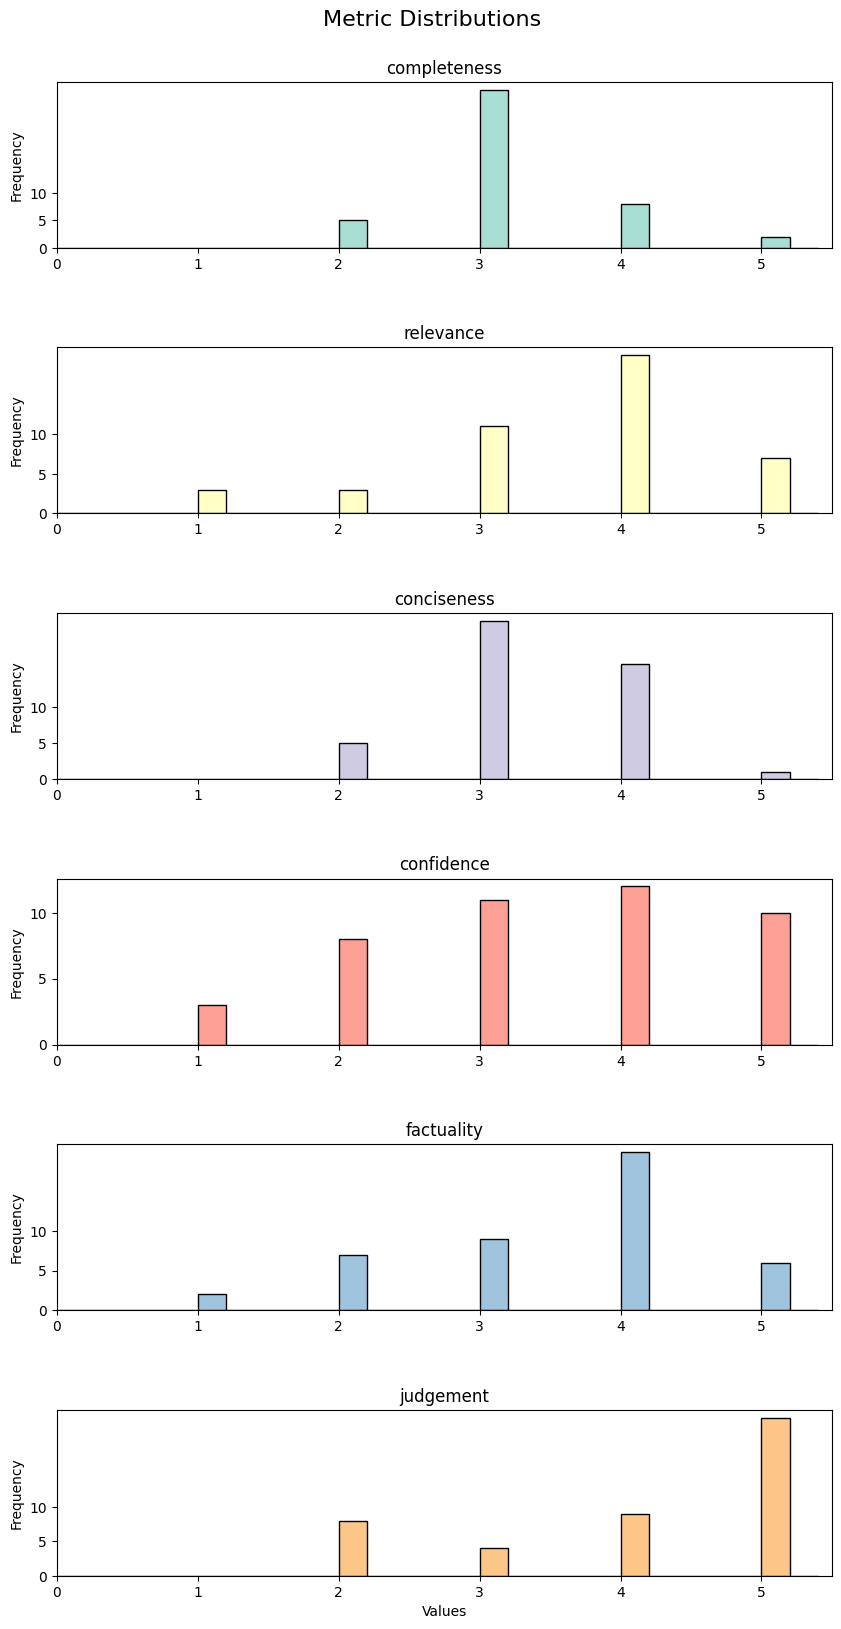

In [18]:
#https://python.langchain.com/v0.2/docs/integrations/chat/openai/
from langsmith.evaluation import evaluate

#Initialize models
for model_id in models:
    
    dataset_name=get_dataset_name(model_id, judge_model) #How the dataset will be named in Langsmith
    dataset_langsmith=create_langsmith_dataset(dataset_name, example_inputs, langsmith_api_key)
    model, tokenizer, pipeline = get_model(model_id)
    print(f"Model: {model_id} loaded")
    model_name=model_id #Since model_name defined as global variable

    # Evaluation
    begin=time.time()

    evaluation_results=evaluate(
        predict, #Function that call our LLM and returns its output
        data=dataset_langsmith.name, #Just using dataset_langsmith doesn't work 
        evaluators=[factor_evaluator], #Evaluators to use
        # metadata={"revision_id": "the version of your pipeline you are testing"},
        experiment_prefix=str(judge_model)+'_judge_with_'+str(model_id) # A prefix for your experiment names to easily identify them
    )

    end=time.time()
    print("Total time taken:",end-begin)

    try: #Sometimes some errors with 1+ Q&A missing

        #Extract metrics and save to df
        #Initialize empty df to be filled with results
        results_df=pd.DataFrame()

        #https://docs.smith.langchain.com/tutorials/Developers/evaluation
        list_of_questions=[x['example'].inputs['question'] for x in evaluation_results]
        list_of_answers=[x['example'].outputs['answer'] for x in evaluation_results]
        list_of_predicted_answers=[x['run'].outputs['output'] for x in evaluation_results]

        #Fill the df with the results
        results_df['questions']=list_of_questions
        results_df['answers']=list_of_answers
        results_df['predicted_answers']=list_of_predicted_answers

        all_runs_metrics=[x['evaluation_results']['results'] for x in evaluation_results] #list of lists with metric names
        all_metric_values=[[{x[i].key: x[i].score} for x in all_runs_metrics] for i in range(len(list_of_metrics))] #List of all completeness scores

        #Check if all keys have the same metric name. 
        same_metric= [all(list(d.keys())[0] == list(sublist[0].keys())[0] for d in sublist) for sublist in all_metric_values]
        assert [True]*len(same_metric)==same_metric

        metric_names=[key for i in range(len(all_metric_values)) for key in all_metric_values[i][0].keys()]
        metric_values=[[list(x.values())[0] for x in all_metric_values[i]] for i in range(len(all_metric_values))]
        
        all_metric_prompts=[[{x[i].key:x[i].value} for x in all_runs_metrics] for i in range(len(list_of_metrics))]
        metric_prompts=[[list(x.values())[0] for x in all_metric_prompts[i]] for i in range(len(all_metric_prompts))]

        # Adding columns to DataFrame
        for col_name, col_values,col_prompts in zip(metric_names, metric_values,metric_prompts):
            results_df[col_name] = col_values
            results_df[col_name+'_prompt'] = col_prompts

        #Save results to Excel
        results_df.to_excel("results_"+str(judge_model.split('/')[1])+'_judge_with_'+str(model_id).replace("/","_")+".xlsx",index=False)

        #Plot figures with distributions of metrics
        plot_figures_metrics(metric_names, metric_values, model_id, judge_model)

    except:
        print("An error occur in plotting metrics")

    # Clear VRAM at the end of each iteration
    del model, tokenizer, pipeline
    torch.cuda.empty_cache()

    print('-'*100)

For real-time inference (below implementation only for meta-llama/Meta-Llama-3.1-8B-Instruct)

In [19]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# import torch
# # del pipeline #Otherwise too much memory is used

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name,device_map='auto')

# #Example of real-time response generation
# messages=[{"role": "user", "content": "What is the chemical formula of water?"}]

# inputs_tokenized = tokenizer.apply_chat_template(
#     messages,
#     tokenize=True,
#     add_generation_prompt=True,
#     return_tensors="pt",
#     return_dict=True,
# ).to("cuda")

# input_ids = inputs_tokenized['input_ids']

# # Generate tokens one by one
# max_length = 256
# output_ids = input_ids
# for _ in range(256):
#     outputs = model.generate(
#         output_ids,
#         max_new_tokens=1,
#         do_sample=True,
#         top_k=50,
#         pad_token_id=tokenizer.eos_token_id
#     )
#     new_token_id = outputs[0, -1].item()
#     if new_token_id == tokenizer.eos_token_id:
#         break
#     output_ids = torch.cat([output_ids, outputs[:, -1:]], dim=1)
#     new_token = tokenizer.decode(new_token_id, skip_special_tokens=True)
#     print(new_token, end="", flush=True)

# print()

Other evaluators from Langsmith

In [20]:
# https://docs.smith.langchain.com/old/evaluation/faq/evaluator-implementations
# https://docs.smith.langchain.com/old/evaluation/quickstart

# from langsmith.evaluation import LangChainStringEvaluator

# eval_llm = ChatOpenAI(model_name=judge_model.split('/')[1], api_key=openai_api_key, temperature=0.0, seed=42)

# #Evaluators
# qa_evaluator = LangChainStringEvaluator("qa", config={"llm": eval_llm}) #LLM just gives 'correct' or 'incorrect' based on reference answer
# context_qa_evaluator = LangChainStringEvaluator("context_qa", config={"llm": eval_llm}) #Also uses reference context of example outputs to do the above
# cot_qa_evaluator = LangChainStringEvaluator("cot_qa", config={"llm": eval_llm}) #Same as above but with chain of thought 'reasoning'

#Prompts Used internally:

# 1) context_qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the context the question is about, and the student's answer. You are asked to score the student's answer as either CORRECT or INCORRECT, 
# based on the context.

# Example Format:
# QUESTION: question here
# CONTEXT: context the question is about here
# STUDENT ANSWER: student's answer here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. 
# It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 


# 2) cot_qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the context the question is about, and the student's answer. You are asked to score the student's answer as either CORRECT or INCORRECT, 
# based on the context.
# Write out in a step by step manner your reasoning to be sure that your conclusion is correct. Avoid simply stating the correct answer at the outset.

# Example Format:
# QUESTION: question here
# CONTEXT: context the question is about here
# STUDENT ANSWER: student's answer here
# EXPLANATION: step by step reasoning here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer.
#  It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 


# 3) qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the student's answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.

# Example Format:
# QUESTION: question here
# STUDENT ANSWER: student's answer here
# TRUE ANSWER: true answer here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer.
#  It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 

Alternatively, use custom prompts as shown below (and set {"prompt": PROMPT} as additional argument inside the config above)

In [21]:
# from langchain_core.prompts.prompt import PromptTemplate

# _PROMPT_TEMPLATE = """You are an expert professor specialized in chemical engineering answers to questions.
# You are grading the following question:
# {query}
# Here is the real answer:
# {answer}
# You are grading the following predicted answer:
# {result}
# Respond with CORRECT or INCORRECT:
# """

# PROMPT = PromptTemplate(
#     input_variables=["query", "result", "answer"], template=_PROMPT_TEMPLATE
# )

Notes: Non-reproducible results, even when seed set (https://platform.openai.com/docs/api-reference/chat/create#chat-create-seed), temperature=0 (top_p should not change when we changed temperature - smaller values result in more constrained and focused response - https://medium.com/@rasithbm/chatopenai-parameters-83bef49f6384)